
# **SimpleCNN**
The `SimpleCNN` class implements a Convolutional Neural Network (CNN) architecture designed for tasks that focus on mesoscopic image proporties, often used in image forensics, such as deepfake detection. This network is based on the principles of the **Meso-4** architecture, a variant of the original **MesoNet** proposed by Afchar et al.

## **Architecture Breakdown**
### **1. Convolutional Blocks**
Each block follows a consistent Pattern: **Convolution** &rarr; **Batch Normalization** &rarr; **ReLU Activation** &rarr; **Max Pooling**
|Block|Input Channels|Output Channels|Kernel Size|Max Pool Size|Output Size (HxW)|Purpose|
|---|---|---|---|---|---|---|
|**Block 1**|3|8|3x3|2x2|128x128|Initial feature extraction|
|**Block 2**|8|8|3x3|2x2|64x64|Further feature extraction|
|**Block 3**|8|16|5x5|2x2|32x32|Increased filter size of wider context|
|**Block 4**|16|16|5x5|2x2|16x16|Final feature map preparation|

* **Batch Normalization (`nn.BatchNorm2d`)**: used after each convolutiona to stablize and accelerate training.
* **Activation (`nn.ReLU`)**: The Rectified Linear Unit is used for non-linearity in the convolutional layers.

### **2. Classifier**
The convolutional feature maps are processed by a fully connected (FC) classifier.
- **Flatten**: The final 3D feature map (16 channels, 16x16 size) is flattened into a vector of size $16\times 16\times 16 = 4096$
- **Hidden Layer (`nn.Linear`)**: A fully connected layer maps the features to **16 units**.
- **Activation (`nn.LeakyReLU`)**: The Leaky ReLU (with a negative slope of 0.1) is used as the activation function for the hidden layer.
- **Regularization (`nn.Dropout`)**: A Dropout layer with $p=0.5$ is applied to prevent over fitting.
- **Output Layer (`nn.Layer`)**: The final fully connected layer maps the 16 units to the number of output classes (`num_classes`).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchsummary

In [3]:
import os
import sys
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
root_name = os.path.basename(project_root)

In [4]:
from src.dataloader import get_data_loaders
from src.model import SimpleCNN
from src.utils import *

In [5]:
DATA_ROOT = '../data/images'
RESULTS_DIR = '../results/simple-cnn'
MODELS_DIR = '../model_checkpoints'

## **Without Data Augmentation**

### **Configurations**

In [6]:
MODEL_NAME = 'simple_cnn'
TASK_NAME = 'deepfake_detection'

In [7]:
BATCH_SIZE = 32
LR = 1e-3
EPOCHS = 30

In [8]:
DEVICE = torch.device(get_device())
torch.backends.cudnn.benchmark = True
set_seed(42)

In [9]:
print(f"Project Root: {root_name}")
print(f"Device: {DEVICE}")

Project Root: deep_fake_detection
Device: cuda


### **Data Transforms & Data Loaders**

In [10]:
# NOTE. Transforms without Augmentation
from torchvision import transforms as tvtf

transform = tvtf.Compose([
    tvtf.Resize((256, 256)),
    tvtf.ToTensor(),
    tvtf.Normalize(
        mean=[0.485, 0.456, 0.406],
         std=[0.229, 0.224, 0.225]
    )
])

In [11]:
def org_dataloaders(root_dir, transform, batch_size=32):
    from torchvision import datasets
    from torch.utils.data import DataLoader
    
    def flip_label(y):
        return 1 - y
    
    # Define path
    train_dir = os.path.join(root_dir, 'train')
    valid_dir = os.path.join(root_dir, 'val')
    
    
    # Create Dataset with ImageFolder
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform, target_transform=flip_label)
    valid_dataset = datasets.ImageFolder(root=valid_dir, transform=transform, target_transform=flip_label)
    
    print(f"Classes found: {train_dataset.class_to_idx}")
    print("APPLYING LABEL FLIP: Mapped 'fake'-> 1 and 'real'-> 0 internally.")
    
    # Loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True)
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True)
    
    return train_loader, valid_loader

In [12]:
train_loader, valid_loader = org_dataloaders(DATA_ROOT, transform, BATCH_SIZE)
print(f"- Train batches: {len(train_loader)}\n- Valid batches: {len(valid_loader)}")

Classes found: {'fake': 0, 'real': 1}
APPLYING LABEL FLIP: Mapped 'fake'-> 1 and 'real'-> 0 internally.
- Train batches: 750
- Valid batches: 125


### **Model Initialization**

In [13]:
model = SimpleCNN(num_classes=2).to(DEVICE)
torchsummary.summary(model, (3, 256, 256), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [32, 8, 256, 256]             216
       BatchNorm2d-2          [32, 8, 256, 256]              16
              ReLU-3          [32, 8, 256, 256]               0
         MaxPool2d-4          [32, 8, 128, 128]               0
            Conv2d-5          [32, 8, 130, 130]             576
       BatchNorm2d-6          [32, 8, 130, 130]              16
              ReLU-7          [32, 8, 130, 130]               0
         MaxPool2d-8            [32, 8, 65, 65]               0
            Conv2d-9           [32, 16, 65, 65]           3,200
      BatchNorm2d-10           [32, 16, 65, 65]              32
             ReLU-11           [32, 16, 65, 65]               0
        MaxPool2d-12           [32, 16, 32, 32]               0
           Conv2d-13           [32, 16, 32, 32]           6,400
      BatchNorm2d-14           [32, 16,

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(), 
    lr=LR, betas=(0.9, 0.999), eps=1e-8)

### **Model Training Process**

In [15]:
history = {
    "model_name": MODEL_NAME,
    "train_losses": [],
    "val_losses": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "val_f1": [],
    "val_auc": [],
    "EPOCHS": EPOCHS,
    "best_accuracy": 0.0,
    "best_epoch": 0,
    "MODEL_SAVED_PATH": ""
}

best_acc = 0.0

In [16]:
for epoch in range(EPOCHS):
    # Train & Evaluate
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(model, valid_loader, criterion, DEVICE)
    
    print(f"[{epoch + 1}/{EPOCHS}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}")
    
    # Record metrics
    history["train_losses"].append(train_loss)
    history["val_losses"].append(valid_loss)
    history["train_accuracy"].append(train_acc)
    history["val_accuracy"].append(valid_acc)
    history["val_f1"].append(valid_f1)
    history["val_auc"].append(valid_auc)
    
    # Save Best Model (based on Accuracy)
    if valid_acc > best_acc:
        best_acc = valid_acc
        # save_name = f"../results/best_{MODEL_NAME}.pth"
        save_name = f"{MODELS_DIR}/best_{MODEL_NAME}.pth"
        save_checkpoint(model, optimizer, save_name)
        
        # Update best stats
        history["best_accuracy"] = best_acc
        history["best_epoch"] = epoch + 1
        history["MODEL_SAVED_PATH"] = save_name
        
    print(f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n")
    

Evaluating: 100%|██████████| 125/125 [00:25<00:00,  4.92it/s]


[1/30] train_acc: 0.5570 - train_loss: 0.6871 - valid_acc: 0.6235 - valid_loss: 0.6510
Checkpoint saved: ../model_checkpoints/best_simple_cnn.pth
	- [current best] epoch: 1 - acc: 0.6235



Evaluating: 100%|██████████| 125/125 [00:21<00:00,  5.80it/s]


[2/30] train_acc: 0.6043 - train_loss: 0.6586 - valid_acc: 0.6350 - valid_loss: 0.6555
Checkpoint saved: ../model_checkpoints/best_simple_cnn.pth
	- [current best] epoch: 2 - acc: 0.6350



Evaluating: 100%|██████████| 125/125 [00:22<00:00,  5.59it/s]


[3/30] train_acc: 0.6178 - train_loss: 0.6469 - valid_acc: 0.6115 - valid_loss: 0.6560
	- [current best] epoch: 2 - acc: 0.6350



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  5.99it/s]


[4/30] train_acc: 0.6311 - train_loss: 0.6355 - valid_acc: 0.6445 - valid_loss: 0.6261
Checkpoint saved: ../model_checkpoints/best_simple_cnn.pth
	- [current best] epoch: 4 - acc: 0.6445



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.09it/s]


[5/30] train_acc: 0.6393 - train_loss: 0.6214 - valid_acc: 0.6532 - valid_loss: 0.6224
Checkpoint saved: ../model_checkpoints/best_simple_cnn.pth
	- [current best] epoch: 5 - acc: 0.6532



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.02it/s]


[6/30] train_acc: 0.6591 - train_loss: 0.6028 - valid_acc: 0.6680 - valid_loss: 0.5986
Checkpoint saved: ../model_checkpoints/best_simple_cnn.pth
	- [current best] epoch: 6 - acc: 0.6680



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.03it/s]


[7/30] train_acc: 0.6665 - train_loss: 0.5884 - valid_acc: 0.6737 - valid_loss: 0.5955
Checkpoint saved: ../model_checkpoints/best_simple_cnn.pth
	- [current best] epoch: 7 - acc: 0.6737



Evaluating: 100%|██████████| 125/125 [00:21<00:00,  5.72it/s]


[8/30] train_acc: 0.6934 - train_loss: 0.5681 - valid_acc: 0.6647 - valid_loss: 0.6104
	- [current best] epoch: 7 - acc: 0.6737



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.09it/s]


[9/30] train_acc: 0.7068 - train_loss: 0.5490 - valid_acc: 0.6895 - valid_loss: 0.5809
Checkpoint saved: ../model_checkpoints/best_simple_cnn.pth
	- [current best] epoch: 9 - acc: 0.6895



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.42it/s]


[10/30] train_acc: 0.7228 - train_loss: 0.5290 - valid_acc: 0.7053 - valid_loss: 0.5751
Checkpoint saved: ../model_checkpoints/best_simple_cnn.pth
	- [current best] epoch: 10 - acc: 0.7053



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.32it/s]


[11/30] train_acc: 0.7365 - train_loss: 0.5074 - valid_acc: 0.7020 - valid_loss: 0.5699
	- [current best] epoch: 10 - acc: 0.7053



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.18it/s]


[12/30] train_acc: 0.7451 - train_loss: 0.4988 - valid_acc: 0.7025 - valid_loss: 0.5730
	- [current best] epoch: 10 - acc: 0.7053



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.12it/s]


[13/30] train_acc: 0.7492 - train_loss: 0.4967 - valid_acc: 0.7137 - valid_loss: 0.5676
Checkpoint saved: ../model_checkpoints/best_simple_cnn.pth
	- [current best] epoch: 13 - acc: 0.7137



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.19it/s]


[14/30] train_acc: 0.7785 - train_loss: 0.4529 - valid_acc: 0.7023 - valid_loss: 0.6499
	- [current best] epoch: 13 - acc: 0.7137



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.25it/s]


[15/30] train_acc: 0.7891 - train_loss: 0.4337 - valid_acc: 0.7230 - valid_loss: 0.6003
Checkpoint saved: ../model_checkpoints/best_simple_cnn.pth
	- [current best] epoch: 15 - acc: 0.7230



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.32it/s]


[16/30] train_acc: 0.7985 - train_loss: 0.4158 - valid_acc: 0.7210 - valid_loss: 0.6278
	- [current best] epoch: 15 - acc: 0.7230



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.37it/s]


[17/30] train_acc: 0.8082 - train_loss: 0.4001 - valid_acc: 0.7140 - valid_loss: 0.6566
	- [current best] epoch: 15 - acc: 0.7230



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.38it/s]


[18/30] train_acc: 0.8172 - train_loss: 0.3900 - valid_acc: 0.7163 - valid_loss: 0.6637
	- [current best] epoch: 15 - acc: 0.7230



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.03it/s]


[19/30] train_acc: 0.8244 - train_loss: 0.3680 - valid_acc: 0.7310 - valid_loss: 0.6673
Checkpoint saved: ../model_checkpoints/best_simple_cnn.pth
	- [current best] epoch: 19 - acc: 0.7310



Evaluating: 100%|██████████| 125/125 [00:23<00:00,  5.43it/s]


[20/30] train_acc: 0.8330 - train_loss: 0.3565 - valid_acc: 0.7365 - valid_loss: 0.6507
Checkpoint saved: ../model_checkpoints/best_simple_cnn.pth
	- [current best] epoch: 20 - acc: 0.7365



Evaluating: 100%|██████████| 125/125 [00:23<00:00,  5.43it/s]


[21/30] train_acc: 0.8412 - train_loss: 0.3420 - valid_acc: 0.6773 - valid_loss: 0.8411
	- [current best] epoch: 20 - acc: 0.7365



Evaluating: 100%|██████████| 125/125 [00:22<00:00,  5.49it/s]


[22/30] train_acc: 0.8129 - train_loss: 0.3919 - valid_acc: 0.7400 - valid_loss: 0.6873
Checkpoint saved: ../model_checkpoints/best_simple_cnn.pth
	- [current best] epoch: 22 - acc: 0.7400



Evaluating: 100%|██████████| 125/125 [00:23<00:00,  5.34it/s]


[23/30] train_acc: 0.8461 - train_loss: 0.3325 - valid_acc: 0.7400 - valid_loss: 0.7362
	- [current best] epoch: 22 - acc: 0.7400



Evaluating: 100%|██████████| 125/125 [00:22<00:00,  5.52it/s]


[24/30] train_acc: 0.8586 - train_loss: 0.3096 - valid_acc: 0.7460 - valid_loss: 0.7219
Checkpoint saved: ../model_checkpoints/best_simple_cnn.pth
	- [current best] epoch: 24 - acc: 0.7460



Evaluating: 100%|██████████| 125/125 [00:24<00:00,  5.17it/s]


[25/30] train_acc: 0.8603 - train_loss: 0.3008 - valid_acc: 0.7348 - valid_loss: 0.7543
	- [current best] epoch: 24 - acc: 0.7460



Evaluating: 100%|██████████| 125/125 [00:22<00:00,  5.44it/s]


[26/30] train_acc: 0.8651 - train_loss: 0.2919 - valid_acc: 0.7470 - valid_loss: 0.7994
Checkpoint saved: ../model_checkpoints/best_simple_cnn.pth
	- [current best] epoch: 26 - acc: 0.7470



Evaluating: 100%|██████████| 125/125 [00:22<00:00,  5.44it/s]


[27/30] train_acc: 0.8697 - train_loss: 0.2868 - valid_acc: 0.7338 - valid_loss: 0.8058
	- [current best] epoch: 26 - acc: 0.7470



Evaluating: 100%|██████████| 125/125 [00:23<00:00,  5.42it/s]


[28/30] train_acc: 0.8738 - train_loss: 0.2758 - valid_acc: 0.7268 - valid_loss: 0.8751
	- [current best] epoch: 26 - acc: 0.7470



Evaluating: 100%|██████████| 125/125 [00:24<00:00,  5.15it/s]


[29/30] train_acc: 0.8774 - train_loss: 0.2704 - valid_acc: 0.7442 - valid_loss: 0.7940
	- [current best] epoch: 26 - acc: 0.7470



Evaluating: 100%|██████████| 125/125 [00:22<00:00,  5.45it/s]

[30/30] train_acc: 0.8825 - train_loss: 0.2632 - valid_acc: 0.7498 - valid_loss: 0.8578
Checkpoint saved: ../model_checkpoints/best_simple_cnn.pth
	- [current best] epoch: 30 - acc: 0.7498



### **Evaluation**

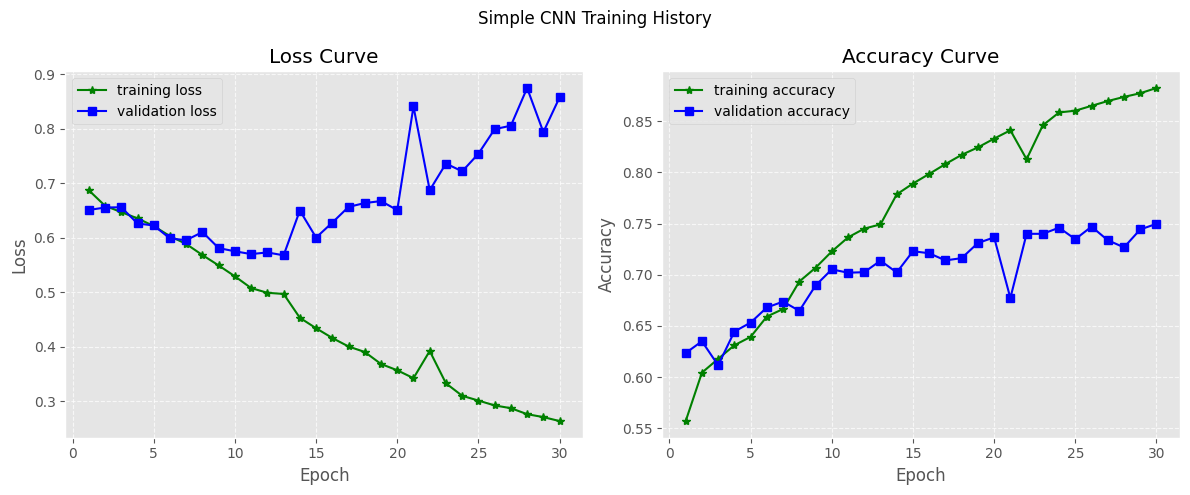

In [17]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

epochs = range(1, len(history["train_losses"]) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plt.suptitle("Simple CNN Training History")

ax[0].plot(epochs, history["train_losses"], label='training loss', marker='*', color='green')
ax[0].plot(epochs, history["val_losses"], label='validation loss', marker='s', color='blue')
ax[0].set_title("Loss Curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].grid(True, linestyle='--', alpha=0.7)

ax[1].plot(epochs, history["train_accuracy"], label='training accuracy', marker='*', color='green')
ax[1].plot(epochs, history["val_accuracy"], label='validation accuracy', marker='s', color='blue')
ax[1].set_title("Accuracy Curve")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].grid(True, linestyle='--', alpha=0.7)

img_save = f"{RESULTS_DIR}/{MODEL_NAME}_{TASK_NAME}.png"
plt.savefig(img_save)
plt.tight_layout()
plt.show()

In [18]:
json_filename = f"{RESULTS_DIR}/{MODEL_NAME}_{TASK_NAME}.json"
save_experiment_json(history, json_filename)

History saved to ../results/simple-cnn/simple_cnn_deepfake_detection.json


Getting predictions: 100%|██████████| 125/125 [00:22<00:00,  5.64it/s]


- Accuracy score: 0.7498
- Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.76      0.75      2000
           1       0.76      0.74      0.75      2000

    accuracy                           0.75      4000
   macro avg       0.75      0.75      0.75      4000
weighted avg       0.75      0.75      0.75      4000



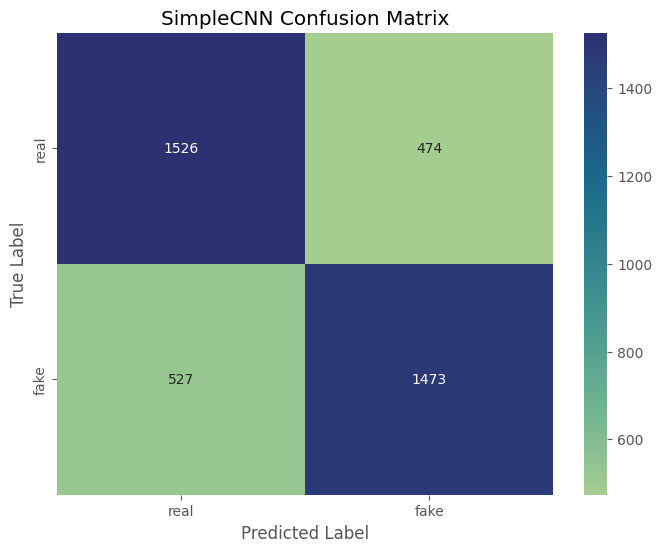

In [19]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_true, y_pred = get_all_predictions(model, valid_loader, DEVICE)
class_names = ['real', 'fake']
    
acc = accuracy_score(y_true, y_pred)
print(f"- Accuracy score: {acc:.4f}")

print(f"- Classification Report:")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='crest',
    xticklabels=class_names,
    yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'SimpleCNN Confusion Matrix')
img_save = f"{RESULTS_DIR}/{MODEL_NAME}_{TASK_NAME}_cfm.png"
plt.savefig(img_save)
plt.show()

## **With Data Augmentation**

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
import sys
import os
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
root_name = os.path.basename(project_root)

In [4]:
from src.dataloader import get_data_loaders
from src.model import SimpleCNN
from src.utils import *

In [5]:
DATA_ROOT = '../data/images'
RESULTS_DIR = '../results/simple-cnn'
MODEL_NAME = 'simpleCNN'
TASK_NAME = 'deepfake_detection_aug'
MODEL_DIR = '../model_checkpoints'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 30
DEVICE = torch.device(get_device())
BENCHMARK = torch.backends.cudnn.benchmark = True
set_seed(42)

In [6]:
print(f"Project Root: {root_name}")
print(f"Device: {DEVICE}")

Project Root: deep_fake_detection
Device: cuda


In [7]:
train_loader, valid_loader = get_data_loaders(DATA_ROOT, MODEL_NAME, BATCH_SIZE)

Class expected: ['real', 'fake']
Label mapping: {'real': 0, 'fake': 1}


In [8]:
import torchsummary

model = SimpleCNN(num_classes=2).to(DEVICE)
torchsummary.summary(model, (3, 256, 256), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [32, 8, 256, 256]             216
       BatchNorm2d-2          [32, 8, 256, 256]              16
              ReLU-3          [32, 8, 256, 256]               0
         MaxPool2d-4          [32, 8, 128, 128]               0
            Conv2d-5          [32, 8, 130, 130]             576
       BatchNorm2d-6          [32, 8, 130, 130]              16
              ReLU-7          [32, 8, 130, 130]               0
         MaxPool2d-8            [32, 8, 65, 65]               0
            Conv2d-9           [32, 16, 65, 65]           3,200
      BatchNorm2d-10           [32, 16, 65, 65]              32
             ReLU-11           [32, 16, 65, 65]               0
        MaxPool2d-12           [32, 16, 32, 32]               0
           Conv2d-13           [32, 16, 32, 32]           6,400
      BatchNorm2d-14           [32, 16,

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [10]:
history = {
    "model_name": MODEL_NAME,
    "train_losses": [], "val_losses": [],
    "train_accuracy": [], "val_accuracy": [],
    "val_f1": [], "val_auc": [],
    "EPOCHS": EPOCHS,
    "best_accuracy": 0.0,
    "best_epoch": 0,
    "MODEL_SAVED_PATH": ""
}

best_acc = 0.0

In [12]:
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(model, valid_loader, criterion, DEVICE)
    
    print(f"[{epoch + 1}/{EPOCHS}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}")
    
    history["train_losses"].append(train_loss)
    history["val_losses"].append(valid_loss)
    history["train_accuracy"].append(train_acc)
    history["val_accuracy"].append(valid_acc)
    history["val_f1"].append(valid_f1)
    history["val_auc"].append(valid_auc)
    
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_name = f"../model_checkpoints/best_{MODEL_NAME}_aug.pth"
        save_checkpoint(model, optimizer, save_name)
        
        history["best_accuracy"] = best_acc
        history["best_epoch"] = epoch + 1
        history["MODEL_SAVED_PATH"] = save_name
        
    print(f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n")

Evaluating: 100%|██████████| 125/125 [00:25<00:00,  4.90it/s]


[1/30] train_acc: 0.5418 - train_loss: 0.6879 - valid_acc: 0.5915 - valid_loss: 0.6709
Checkpoint saved: ../model_checkpoints/best_simpleCNN_aug.pth
	- [current best] epoch: 1 - acc: 0.5915



Evaluating: 100%|██████████| 125/125 [00:16<00:00,  7.56it/s]


[2/30] train_acc: 0.5730 - train_loss: 0.6768 - valid_acc: 0.6318 - valid_loss: 0.6556
Checkpoint saved: ../model_checkpoints/best_simpleCNN_aug.pth
	- [current best] epoch: 2 - acc: 0.6318



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.54it/s]


[3/30] train_acc: 0.5936 - train_loss: 0.6674 - valid_acc: 0.6370 - valid_loss: 0.6491
Checkpoint saved: ../model_checkpoints/best_simpleCNN_aug.pth
	- [current best] epoch: 3 - acc: 0.6370



Evaluating: 100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


[4/30] train_acc: 0.5913 - train_loss: 0.6651 - valid_acc: 0.6310 - valid_loss: 0.6398
	- [current best] epoch: 3 - acc: 0.6370



Evaluating: 100%|██████████| 125/125 [00:16<00:00,  7.66it/s]


[5/30] train_acc: 0.5998 - train_loss: 0.6608 - valid_acc: 0.6480 - valid_loss: 0.6348
Checkpoint saved: ../model_checkpoints/best_simpleCNN_aug.pth
	- [current best] epoch: 5 - acc: 0.6480



Evaluating: 100%|██████████| 125/125 [00:16<00:00,  7.41it/s]


[6/30] train_acc: 0.6038 - train_loss: 0.6583 - valid_acc: 0.6392 - valid_loss: 0.6413
	- [current best] epoch: 5 - acc: 0.6480



Evaluating: 100%|██████████| 125/125 [00:16<00:00,  7.48it/s]


[7/30] train_acc: 0.6094 - train_loss: 0.6525 - valid_acc: 0.6420 - valid_loss: 0.6379
	- [current best] epoch: 5 - acc: 0.6480



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.19it/s]


[8/30] train_acc: 0.6114 - train_loss: 0.6489 - valid_acc: 0.6640 - valid_loss: 0.6194
Checkpoint saved: ../model_checkpoints/best_simpleCNN_aug.pth
	- [current best] epoch: 8 - acc: 0.6640



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.23it/s]


[9/30] train_acc: 0.6120 - train_loss: 0.6462 - valid_acc: 0.6667 - valid_loss: 0.6149
Checkpoint saved: ../model_checkpoints/best_simpleCNN_aug.pth
	- [current best] epoch: 9 - acc: 0.6667



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.38it/s]


[10/30] train_acc: 0.6156 - train_loss: 0.6437 - valid_acc: 0.6683 - valid_loss: 0.6194
Checkpoint saved: ../model_checkpoints/best_simpleCNN_aug.pth
	- [current best] epoch: 10 - acc: 0.6683



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.02it/s]


[11/30] train_acc: 0.6234 - train_loss: 0.6391 - valid_acc: 0.6657 - valid_loss: 0.6133
	- [current best] epoch: 10 - acc: 0.6683



Evaluating: 100%|██████████| 125/125 [00:18<00:00,  6.64it/s]


[12/30] train_acc: 0.6259 - train_loss: 0.6359 - valid_acc: 0.6320 - valid_loss: 0.6333
	- [current best] epoch: 10 - acc: 0.6683



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.23it/s]


[13/30] train_acc: 0.6289 - train_loss: 0.6350 - valid_acc: 0.6623 - valid_loss: 0.6136
	- [current best] epoch: 10 - acc: 0.6683



Evaluating: 100%|██████████| 125/125 [00:16<00:00,  7.41it/s]


[14/30] train_acc: 0.6274 - train_loss: 0.6331 - valid_acc: 0.6687 - valid_loss: 0.6040
Checkpoint saved: ../model_checkpoints/best_simpleCNN_aug.pth
	- [current best] epoch: 14 - acc: 0.6687



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.24it/s]


[15/30] train_acc: 0.6328 - train_loss: 0.6284 - valid_acc: 0.6653 - valid_loss: 0.6041
	- [current best] epoch: 14 - acc: 0.6687



Evaluating: 100%|██████████| 125/125 [00:27<00:00,  4.56it/s]


[16/30] train_acc: 0.6363 - train_loss: 0.6254 - valid_acc: 0.6583 - valid_loss: 0.6219
	- [current best] epoch: 14 - acc: 0.6687



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.20it/s]


[17/30] train_acc: 0.6334 - train_loss: 0.6250 - valid_acc: 0.6575 - valid_loss: 0.6184
	- [current best] epoch: 14 - acc: 0.6687



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.30it/s]


[18/30] train_acc: 0.6373 - train_loss: 0.6224 - valid_acc: 0.6617 - valid_loss: 0.6122
	- [current best] epoch: 14 - acc: 0.6687



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.49it/s]


[19/30] train_acc: 0.6431 - train_loss: 0.6191 - valid_acc: 0.6610 - valid_loss: 0.6059
	- [current best] epoch: 14 - acc: 0.6687



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.38it/s]


[20/30] train_acc: 0.6424 - train_loss: 0.6183 - valid_acc: 0.6747 - valid_loss: 0.5998
Checkpoint saved: ../model_checkpoints/best_simpleCNN_aug.pth
	- [current best] epoch: 20 - acc: 0.6747



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.37it/s]


[21/30] train_acc: 0.6462 - train_loss: 0.6154 - valid_acc: 0.6705 - valid_loss: 0.6105
	- [current best] epoch: 20 - acc: 0.6747



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.09it/s]


[22/30] train_acc: 0.6468 - train_loss: 0.6145 - valid_acc: 0.6690 - valid_loss: 0.6045
	- [current best] epoch: 20 - acc: 0.6747



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.00it/s]


[23/30] train_acc: 0.6555 - train_loss: 0.6085 - valid_acc: 0.6695 - valid_loss: 0.6086
	- [current best] epoch: 20 - acc: 0.6747



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.29it/s]


[24/30] train_acc: 0.6487 - train_loss: 0.6113 - valid_acc: 0.6518 - valid_loss: 0.6463
	- [current best] epoch: 20 - acc: 0.6747



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.45it/s]


[25/30] train_acc: 0.6531 - train_loss: 0.6073 - valid_acc: 0.6750 - valid_loss: 0.6154
Checkpoint saved: ../model_checkpoints/best_simpleCNN_aug.pth
	- [current best] epoch: 25 - acc: 0.6750



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.33it/s]


[26/30] train_acc: 0.6518 - train_loss: 0.6101 - valid_acc: 0.6785 - valid_loss: 0.6229
Checkpoint saved: ../model_checkpoints/best_simpleCNN_aug.pth
	- [current best] epoch: 26 - acc: 0.6785



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.11it/s]


[27/30] train_acc: 0.6509 - train_loss: 0.6040 - valid_acc: 0.6753 - valid_loss: 0.6173
	- [current best] epoch: 26 - acc: 0.6785



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.52it/s]


[28/30] train_acc: 0.6581 - train_loss: 0.6027 - valid_acc: 0.6847 - valid_loss: 0.6015
Checkpoint saved: ../model_checkpoints/best_simpleCNN_aug.pth
	- [current best] epoch: 28 - acc: 0.6847



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.35it/s]


[29/30] train_acc: 0.6542 - train_loss: 0.6052 - valid_acc: 0.6675 - valid_loss: 0.6060
	- [current best] epoch: 28 - acc: 0.6847



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.39it/s]

[30/30] train_acc: 0.6551 - train_loss: 0.6025 - valid_acc: 0.6697 - valid_loss: 0.6404
	- [current best] epoch: 28 - acc: 0.6847



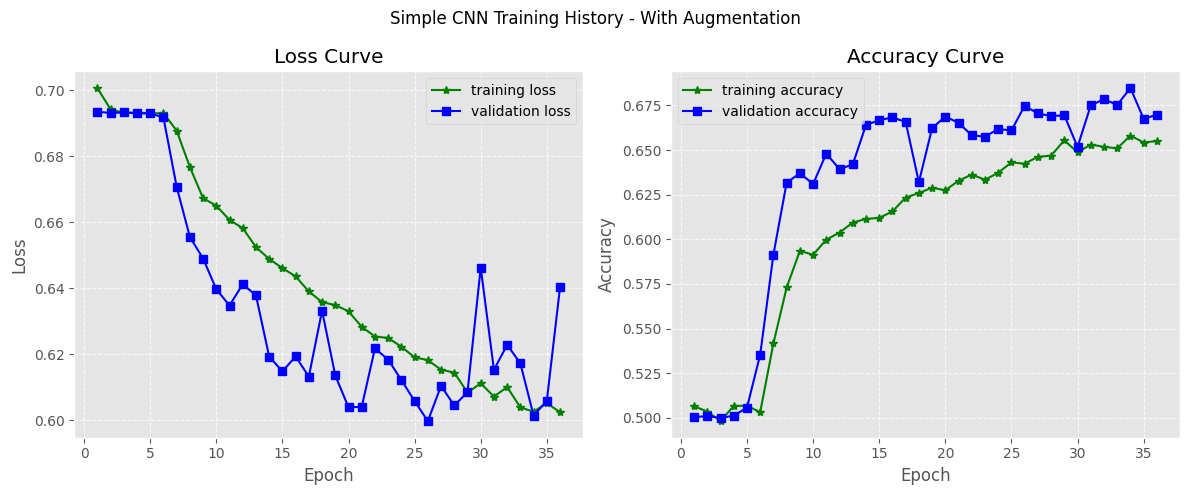

In [13]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

epochs = range(1, len(history["train_losses"]) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plt.suptitle("Simple CNN Training History - With Augmentation")

ax[0].plot(epochs, history["train_losses"], label='training loss', marker='*', color='green')
ax[0].plot(epochs, history["val_losses"], label='validation loss', marker='s', color='blue')
ax[0].set_title("Loss Curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].grid(True, linestyle='--', alpha=0.7)

ax[1].plot(epochs, history["train_accuracy"], label='training accuracy', marker='*', color='green')
ax[1].plot(epochs, history["val_accuracy"], label='validation accuracy', marker='s', color='blue')
ax[1].set_title("Accuracy Curve")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].grid(True, linestyle='--', alpha=0.7)

img_save = f"{RESULTS_DIR}/{MODEL_NAME}_{TASK_NAME}_aug.png"
plt.savefig(img_save)
plt.tight_layout()
plt.show()

In [14]:
json_filename = f"{RESULTS_DIR}/{MODEL_NAME}_{TASK_NAME}.json"
save_experiment_json(history, json_filename)

History saved to ../results/simple-cnn/simpleCNN_deepfake_detection_aug.json


Getting predictions: 100%|██████████| 125/125 [00:19<00:00,  6.37it/s]


- Accuracy score: 0.6697
- Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.63      0.66      2000
           1       0.66      0.70      0.68      2000

    accuracy                           0.67      4000
   macro avg       0.67      0.67      0.67      4000
weighted avg       0.67      0.67      0.67      4000



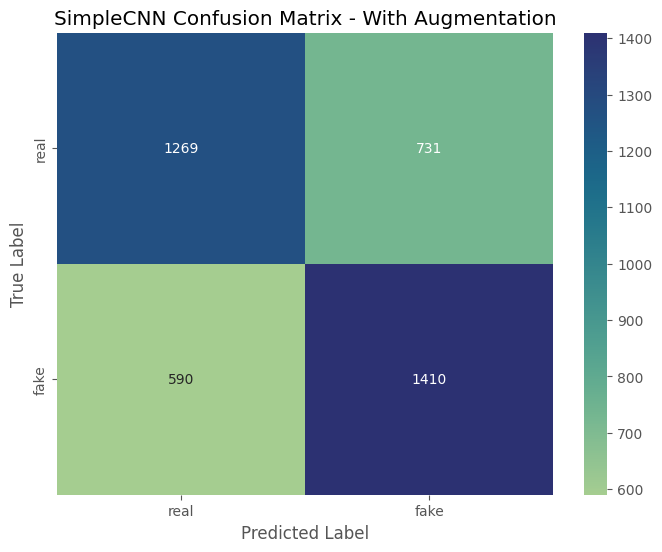

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_true, y_pred = get_all_predictions(model, valid_loader, DEVICE)
class_names = ['real', 'fake']
    
acc = accuracy_score(y_true, y_pred)
print(f"- Accuracy score: {acc:.4f}")

print(f"- Classification Report:")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='crest',
    xticklabels=class_names,
    yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'SimpleCNN Confusion Matrix - With Augmentation')
img_save = f"{RESULTS_DIR}/{MODEL_NAME}_{TASK_NAME}_cfm.png"
plt.savefig(img_save)
plt.show()